# EEG classifier

In [1]:
import os
import numpy as np
import time, datetime
import matplotlib.pyplot as plt
from collections import OrderedDict
import pandas as pd

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.autograd import Variable

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay
from sklearn.metrics import classification_report

In [2]:
# check if you have a GPU
is_cuda = torch.cuda.is_available()
if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

GPU is available


In [3]:
# Get train and test data
data_path = "../dataset/"

for dirname, _, filenames in os.walk(data_path):
    for filename in filenames:
        if "train" in filename:
            train_path = os.path.join(dirname, filename)
        if "test" in filename:
            test_path = os.path.join(dirname, filename)

In [4]:
def encode_target(target):
    if target == -55:
        return 0
    else:
        return 1

In [5]:
def display_conf_matrix(y_true, y_pred, classes):
    ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                                            display_labels=classes,
                                            cmap=plt.cm.Greens)
    plt.title("Confusion Matrix")
    plt.show()

In [6]:
def display_roc_curve(y_true, y_pred, classes):
    RocCurveDisplay.from_predictions(
    y_true,
    y_pred,
    color="darkorange",
    )
    plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
    plt.axis("square")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    # this title only works with two classes
    plt.title(f"ROC curves:\n{classes[0]} vs {classes[1]}")
    plt.legend()
    plt.show()

In [7]:
def create_data_loader(train_df, test_df, batch_size = 100, val_split=0.3):
    
    # transform dataframe to numpy array
    train_data = train_df.to_numpy()
    test_data = test_df.to_numpy()
    
    # create x and y, normalized
    x_train = train_data[:, :-1]/train_data[:, :-1].max()
    x_test = test_data[:, :-1]/test_data[:, :-1].max()
    y_train = train_data[:, -1]
    y_test = test_data[:, -1]
    
    # select just 178 points
    x_train = x_train[:, :178]
    x_test = x_test[:, :178]

    # create tensor dataset of x and y
    train_dataset = torch.utils.data.TensorDataset(torch.from_numpy(x_train).float(),
                                                   torch.from_numpy(y_train))
    test_dataset = torch.utils.data.TensorDataset(torch.from_numpy(x_test).float(),
                                                  torch.from_numpy(y_test))
    
    # split dataset in train, val and test
    train_len = train_data.shape[0]
    val_len = int(train_len * val_split)
    train_len -= val_len

    # shuffle train and validade data
    train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_len, val_len])

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

    return train_loader, val_loader, test_loader

In [8]:
class RNNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim, nonlinearity_type):
        
        super(RNNModel, self).__init__()
        
        # Number of hidden dimensions
        self.hidden_dim = hidden_dim
        
        # Number of hidden layers
        self.layer_dim = layer_dim
        
        # Non linearity type (tahn or relu)
        self.nonlinearity_type = nonlinearity_type
        
        # RNN
        self.rnn = nn.RNN(input_dim, hidden_dim, layer_dim, batch_first=True, nonlinearity=nonlinearity_type)
        
        # Readout layer
        self.fc = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_()
            
        # One time step
        out, _ = self.rnn(x, h0.detach())
        out = self.fc(out[:, -1, :]) 
        return out

In [9]:
def test_model(model, test_loader):
    correct = 0
    total = 0
    y_true = []
    y_pred = []

    for signals, labels in test_loader:
        signals = signals.unsqueeze(1)

        # Forward propagation
        outputs = model(signals)

        # Get predictions from the maximum value
        predicted = torch.max(outputs.data, 1)[1]

        # Total number of labels
        total += labels.size(0)

        correct += (predicted == labels).sum()
        y_true+=labels
        y_pred+=predicted

    accuracy = 100 * correct / float(total)

    # Print validade loss
    print('test_accuracy: {} %'.format(accuracy.numpy().round()))
    return y_true, y_pred

In [10]:
def train_model(model, train_loader, val_loader, num_epochs):
    val_loss = []
    val_accuracy = []
    val_iteration = []
    y_true=[]
    y_pred=[]
    
    count = 0
    for epoch in range(num_epochs):
        for i, (signals, labels) in enumerate(train_loader):

            train = signals.unsqueeze(1)
            labels = labels.long()

            # Clear gradients
            optimizer.zero_grad()

            # Forward propagation
            outputs = model(train)

            # Calculate softmax and ross entropy loss
            loss = error(outputs, labels)

            # Calculating gradients
            loss.backward()

            # Update parameters
            optimizer.step()

            count += 1

            if count % (test_df.shape[0]//batch_size) == 0:
                # Calculate Accuracy         
                correct = 0
                total = 0
                # Iterate through test dataset
                for signals, labels in val_loader:
                    signals = signals.unsqueeze(1)

                    # Forward propagation
                    outputs = model(signals)

                    # Get predictions from the maximum value
                    predicted = torch.max(outputs.data, 1)[1]

                    # Total number of labels
                    total += labels.size(0)

                    correct += (predicted == labels).sum()

                accuracy = 100 * correct / float(total)

                # store loss and iteration
                val_loss.append(loss.data)
                val_accuracy.append(accuracy)
                val_iteration.append(count)
                if count % 100 == 0:
                    print('iteration: {}  val_loss: {}  val_accuracy: {} %'.format(count, loss.data, accuracy))
    return val_loss, val_accuracy, val_iteration, y_true, y_pred

## Load data

In [11]:
# load csv
train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

# remove unnamed columns
train_df = train_df.iloc[: , 3:]
test_df = test_df.iloc[: , 3:]

# change target value
train_df.target = train_df.target.apply(encode_target)
test_df.target = test_df.target.apply(encode_target)

In [12]:
print(f"training size: {train_df.shape[0]} \ntest size: {test_df.shape[0]}")

training size: 4803 
test size: 1177


In [13]:
# classes
np.unique(train_df.to_numpy()[:,-1])

array([0., 1.])

## Create dataloader

In [14]:
val_split = 0.2
batch_size = 32

In [15]:
train_loader, val_loader, test_loader = create_data_loader(train_df, test_df, batch_size = batch_size, val_split=val_split)

## Train and test model

In [16]:
# Model params
num_epochs = 50

input_dim = 178   # input dimension
hidden_dim = 32  # hidden layer dimension
layer_dim = 2     # number of hidden layers
output_dim = 2   # output dimension

In [17]:
# Initiate RNN model
model = RNNModel(input_dim, hidden_dim, layer_dim, output_dim, "relu")

# Cross Entropy Loss 
error = nn.CrossEntropyLoss()

# SGD Optimizer
learning_rate = 0.1
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [18]:
# Train model
val_loss, val_accuracy, val_iteration, y_true, y_pred = train_model(model, train_loader, val_loader, num_epochs)

iteration: 900  val_loss: 0.35529449582099915  val_accuracy: 88.64583587646484 %
iteration: 1800  val_loss: 0.20921333134174347  val_accuracy: 87.08333587646484 %
iteration: 2700  val_loss: 0.030300049111247063  val_accuracy: 84.375 %
iteration: 3600  val_loss: 0.009322840720415115  val_accuracy: 85.10416412353516 %
iteration: 4500  val_loss: 0.0038406653329730034  val_accuracy: 85.41666412353516 %
iteration: 5400  val_loss: 0.0014153157826513052  val_accuracy: 85.3125 %


In [19]:
# Test model
y_true_test, y_pred_test = test_model(model, test_loader)

test_accuracy: 85.0 %


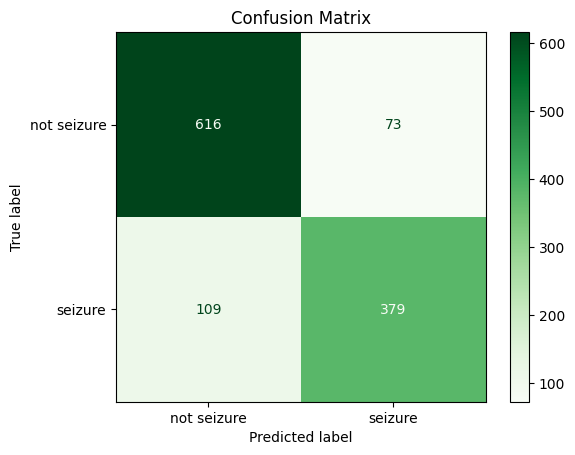

In [20]:
display_conf_matrix(y_true_test, y_pred_test, classes=["not seizure","seizure"])

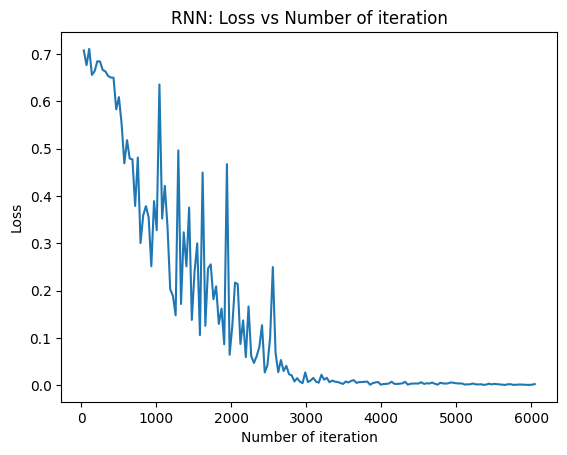

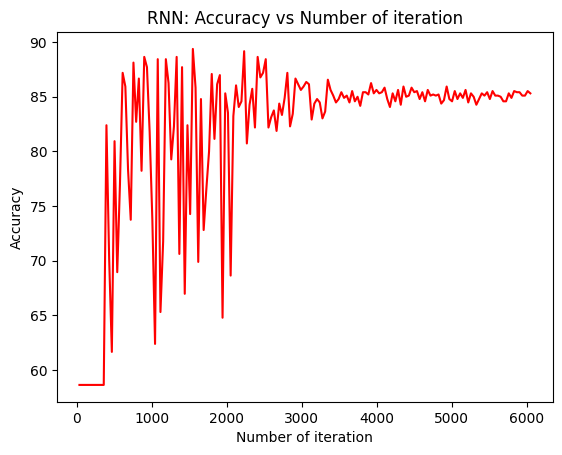

In [21]:
# visualization loss 
plt.plot(val_iteration,val_loss)
plt.xlabel("Number of iteration")
plt.ylabel("Loss")
plt.title("RNN: Loss vs Number of iteration")
plt.show()

# visualization accuracy 
plt.plot(val_iteration,val_accuracy, color = "red")
plt.xlabel("Number of iteration")
plt.ylabel("Accuracy")
plt.title("RNN: Accuracy vs Number of iteration")
plt.show()

## Test model with an experimental data

In [22]:
def test_data_loader(test_df, batch_size = 100):
    
    # transform dataframe to numpy array
    test_data = test_df.to_numpy()
    
    # create x and y
    x_test = test_data[:, :-1]/test_data[:, :-1].max()
    y_test = test_data[:, -1]

    # create tensor dataset of x and y
    test_dataset = torch.utils.data.TensorDataset(torch.from_numpy(x_test).float(),
                                                  torch.from_numpy(y_test).long())

    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

    return test_loader

In [23]:
df = pd.read_csv("../dataset/experimental_data.csv")

In [24]:
# Remove first column
final_test_df = df.iloc[: , 1:]

In [25]:
def get_target(target):
    if target==2:
        return 0
    elif target==1:
        return 1
    else:
        return np.nan

In [26]:
# select targets 1 and 2
final_test_df.y = final_test_df.y.apply(get_target)

In [27]:
# count classes
final_test_df.y.value_counts(dropna=False)

NaN    6900
1.0    2300
0.0    2300
Name: y, dtype: int64

In [28]:
# drop missing values
final_test_df.dropna(subset=["y"], inplace=True)

In [29]:
test_loader_exp = test_data_loader(final_test_df, batch_size = batch_size)

In [30]:
# Test model
y_true_exp, y_pred_exp = test_model(model, test_loader_exp)

test_accuracy: 87.0 %


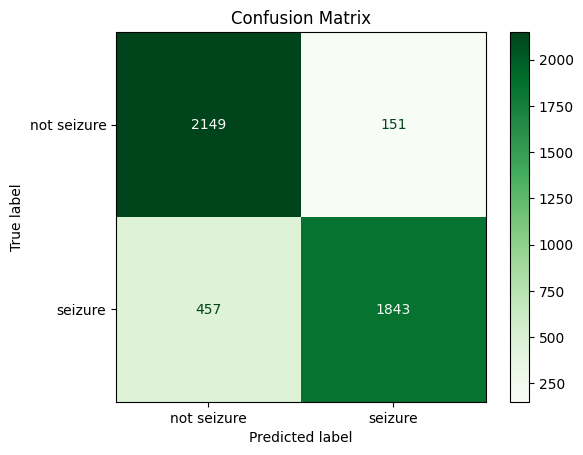

In [31]:
display_conf_matrix(y_true_exp, y_pred_exp, classes=["not seizure","seizure"])

In [32]:
print(classification_report(y_true_exp, y_pred_exp, target_names=["not seizure","seizure"]))

              precision    recall  f1-score   support

 not seizure       0.82      0.93      0.88      2300
     seizure       0.92      0.80      0.86      2300

    accuracy                           0.87      4600
   macro avg       0.87      0.87      0.87      4600
weighted avg       0.87      0.87      0.87      4600



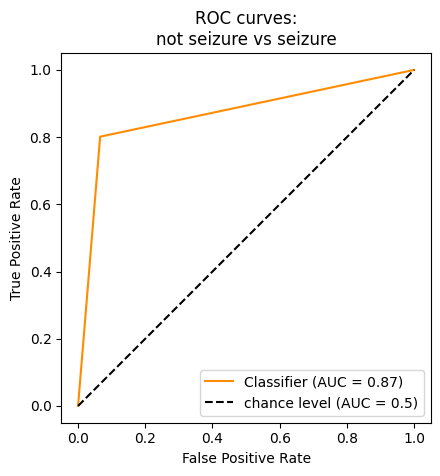

In [33]:
display_roc_curve(y_true_exp, y_pred_exp, classes=["not seizure","seizure"])